In [17]:
from call_functions import *
import matplotlib.pyplot as plt
import plotly.express as px

## Comparaison between $fAB$ and $fAB$ mini convergence

Norme dans $H^{1/2}\times L^2$

In [18]:
# ------------------------------
# Parameters to tune
# ------------------------------

x0 = 0
L = 2 * np.pi
Nx = 2**5 +1
Nf = Nx // 2
dt = 1e-3
a = 1
g = 1
gain = 1
T_start = 0
T = 500
N_ini_fq = 2**2

# ------------------------------
# Space discretization
# ------------------------------

dx = L / Nx
Lx = L - dx
xspan = np.arange(x0, Lx + dx, dx)
frequences = np.fft.fftfreq(Nx, dx) * 2 * np.pi
frequences2 = fftfreq(Nx, dx) * 2 * np.pi # same as above

# ------------------------------
# Time discretization
# ------------------------------

T_end = T_start + T
tspan = np.arange(T_start, T_end + dt, dt)
Nt = len(tspan)

# ------------------------------
# Matrix computations
# ------------------------------

# ------------------------------
# 1) DFT and iDFT Matrices (as well as no mean matrices)
DFT = 1 / Nx * getDFT(Nx)
iDFT = getiDFT(Nx)

# ------------------------------
# 2) True matrix A not in Fourier
O = np.zeros((Nx, Nx))
I = np.eye(Nx)
G = Matrix_A_dz(Nx, dx)
_, C = GetC(np.abs(xspan - np.pi) <= a)
obs_space = np.abs(xspan - np.pi) <= a
C = -np.dot(C.T, C)
A = np.block([[O, -I], [G, O]])
AB = np.block([[O, -I], [G, C]])

# ------------------------------
# 3) True matrix A in Fourier
fO = np.zeros((2 * Nf + 1, 2 * Nf + 1))
fI = -np.eye(2 * Nf + 1)
fF = np.diag(np.abs(np.concatenate((np.arange(0, Nf + 1), np.arange(-Nf, 0)))))
frequences = fftfreq(Nx, dx) * 2 * np.pi  # Assuming the previously defined fftfreq function
fC = np.real(-((a * np.exp((-1j * np.pi) * (frequences.reshape(-1, 1) - frequences))) / np.pi) * np.sinc(a * (frequences.reshape(-1, 1) - frequences) / np.pi))
fA = np.block([[fO, fI], [fF, fO]])
fAB = np.block([[fO, fI], [fF, fC]])

# Matrix that deletes the mean
Pi_nm = np.diag(np.concatenate((np.zeros(1),np.ones(Nx-1))))

# Modified fAB
fAB_mod_nm = np.block([[fO, fI], [fF, Pi_nm @ fC]])
fAB_mod2_nm = np.block([[fO, fI], [fF, fC @ Pi_nm]])


# vector with list of all the positive frequencices
pos_frequences = frequences[1:int((len(frequences)-1)/2)+1]

# Matrix that deletes the mean and the high frequencies
Pi_bf = np.diag(np.concatenate((np.zeros(1),(pos_frequences <= N_ini_fq),(pos_frequences <= N_ini_fq)[::-1])))
Pi_hf = np.diag(np.concatenate((np.zeros(1),(pos_frequences > N_ini_fq),(pos_frequences > N_ini_fq)[::-1])))

# second Modified fAB
fAB_mod_bf = np.block([[fO, fI], [fF, Pi_bf @ fC]])
fAB_mod2_bf = np.block([[fO, fI], [fF, fC @ Pi_bf]])


# ------------------------------
# 4) True matrix A in Fourier (mini)
Nfmini = N_ini_fq
Nxmini = 2*Nfmini + 1
dxmini = L / Nxmini
fOmini = np.zeros((2 * Nfmini + 1, 2 * Nfmini + 1))
fImini = -np.eye(2 * Nfmini + 1)
fFmini = np.diag(np.abs(np.concatenate((np.arange(0, Nfmini + 1), np.arange(-Nfmini, 0)))))
frequencesmini = fftfreq(Nxmini, dxmini) * 2 * np.pi  # Assuming the previously defined fftfreq function
fCmini = np.real(-((a * np.exp((-1j * np.pi) * (frequencesmini.reshape(-1, 1) - frequencesmini))) / np.pi) * np.sinc(a * (frequencesmini.reshape(-1, 1) - frequencesmini) / np.pi))
fABmini = np.block([[fOmini, fImini], [fFmini, fCmini]])

# Matrix that deletes the mean
Pimini_nm = np.diag(np.concatenate((np.zeros(1),np.ones(Nxmini-1))))

# Modified fAB
fABmini_mod_nm = np.block([[fOmini, fImini], [fFmini, Pimini_nm @ fCmini]])

# # vector with list of all the positive frequencices
# pos_frequences = frequences[1:int((len(frequences)-1)/2)+1]

# # Matrix that deletes the mean and the high frequencies
# Pi_bf = np.diag(np.concatenate((np.zeros(1),(pos_frequences <= N_ini_fq),(pos_frequences <= N_ini_fq)[::-1])))
# Pi_hf = np.diag(np.concatenate((np.zeros(1),(pos_frequences > N_ini_fq),(pos_frequences > N_ini_fq)[::-1])))

# # second Modified fAB
# fAB_mod_bf = np.block([[fO, fI], [fF, Pi_bf @ fC]])

In [19]:
np.random.seed(1)
X0_mix = create_Fourier_X0(N_ini_fq,N_ini_fq, Nx, dx)
X0mini_mix = np.zeros(1)
for i,val in enumerate(X0_mix):
    if X0_mix[i] > 1e-12: X0mini_mix = np.concatenate((X0mini_mix,np.array([val])))

In [20]:
X0_test = np.concatenate((np.zeros(1),np.random.rand(4),np.zeros(Nx-5)))
X0mini_test = np.concatenate((np.zeros(1),np.random.rand(4),np.zeros(4)))

In [21]:
X0mini_test

array([0.        , 0.68650093, 0.83462567, 0.01828828, 0.75014431,
       0.        , 0.        , 0.        , 0.        ])

In [25]:
# Creating fX0_sin, fX0_cos and fX0_mix

fX0_mix = np.concatenate((X0_mix,X0_mix))
fX0mini_mix = np.concatenate((X0mini_mix,1j * X0mini_mix @ np.diag(np.sqrt(np.abs(frequencesmini)))))

fX0_test = np.concatenate((X0_test,X0_test))
fX0mini_test = np.concatenate((X0mini_test,1j*X0mini_test @ np.diag(np.sqrt(np.abs(frequencesmini)))))

In [26]:
# ------------------------------
# Time integration scheme
# ------------------------------

# def Euler_Explicit(mat, X0, tspan):
#     X = np.zeros((X0.shape[0],tspan.shape[0])) + np.zeros((X0.shape[0],tspan.shape[0]))*1j
#     dt = tspan[1] - tspan[0]
#     X[:,0] = X0
#     for i in range(1,len(tspan)):
#         X[:,i] = X[:,i-1] + dt * mat @ X[:,i-1]
#     return X

In [66]:
# ------------------------------
# Time integration with fX0_mix
# ------------------------------

fX_sol_EE_fAB_mix = Euler_Explicit(fAB,fX0_mix,tspan)
print('1st edo : done')
fX_sol_EE_fAB_mod_nm_mix = Euler_Explicit(fAB_mod_nm,fX0_mix,tspan)
print('2nd edo : done')
fX_sol_EE_fAB_mod_bf_mix = Euler_Explicit(fAB_mod_bf,fX0_mix,tspan)
print('3rd edo : done')

1st edo : done
2nd edo : done
3rd edo : done


In [65]:
# ------------------------------
# Time integration with fX0_mix
# ------------------------------

fX_sol_EE_fABmini_mix = Euler_Explicit(fABmini,fX0mini_mix,tspan)
print('1st edo : done')
fX_sol_EE_fABmini_mod_nm_mix = Euler_Explicit(fABmini_mod_nm,fX0mini_mix,tspan)
print('2nd edo : done')

1st edo : done
2nd edo : done


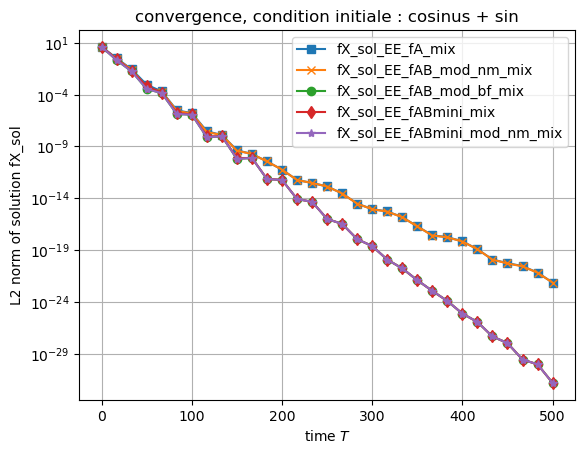

In [67]:
steps = tspan.shape[0]//30
plt.semilogy(tspan[::steps],H_half_times_L2_norm(fX_sol_EE_fAB_mix[0:,::steps],frequences),'-s',label='fX_sol_EE_fA_mix')
plt.semilogy(tspan[::steps],H_half_times_L2_norm(fX_sol_EE_fAB_mod_nm_mix[0:,::steps],frequences),'-x',label='fX_sol_EE_fAB_mod_nm_mix')
plt.semilogy(tspan[::steps],H_half_times_L2_norm(fX_sol_EE_fAB_mod_bf_mix[0:,::steps],frequences),'-o',label='fX_sol_EE_fAB_mod_bf_mix')
plt.semilogy(tspan[::steps],H_half_times_L2_norm(fX_sol_EE_fABmini_mix[0:,::steps],frequencesmini),'-d',label='fX_sol_EE_fABmini_mix')
plt.semilogy(tspan[::steps],H_half_times_L2_norm(fX_sol_EE_fABmini_mod_nm_mix[0:,::steps],frequencesmini),'-*',label='fX_sol_EE_fABmini_mod_nm_mix')
plt.title(r'convergence, condition initiale : cosinus + sin')
plt.grid()
plt.legend()
plt.xlabel(r'time $T$')
plt.ylabel(r'L2 norm of solution fX_sol')
plt.show()

## Convergence rate $\gamma$

In [71]:
nb_gamma = 10
gamma_list = (10*np.ones(nb_gamma))**np.linspace(-3,3,nb_gamma)

In [72]:
conv_factor_the = np.zeros(nb_gamma)
fX_sol = {}
for i,gamma in enumerate(gamma_list):
    fABmini_i = np.block([[fOmini, fImini], [fFmini, gamma * (Pimini_nm @ fCmini)]])
    conv_factor_the[i] = largest_nonzero_eigenvalue(fABmini_i)
    print('done for ode nb :',i+1)
    fX_sol[i] = Euler_Explicit(fABmini_i,fX0mini_test,tspan)

done for ode nb : 1
done for ode nb : 2
done for ode nb : 3
done for ode nb : 4
done for ode nb : 5
done for ode nb : 6
done for ode nb : 7
done for ode nb : 8
done for ode nb : 9
done for ode nb : 10


/var/folders/vb/z01wks0d25n399v1c2rv_r6000mb9z/T/ipykernel_29360/188983546.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  conv_factor_obs[i] = np.polyfit(tspan[::steps],np.log(H_half_times_L2_norm(fX_sol[i][0:,::steps],frequencesmini)),1)[0]


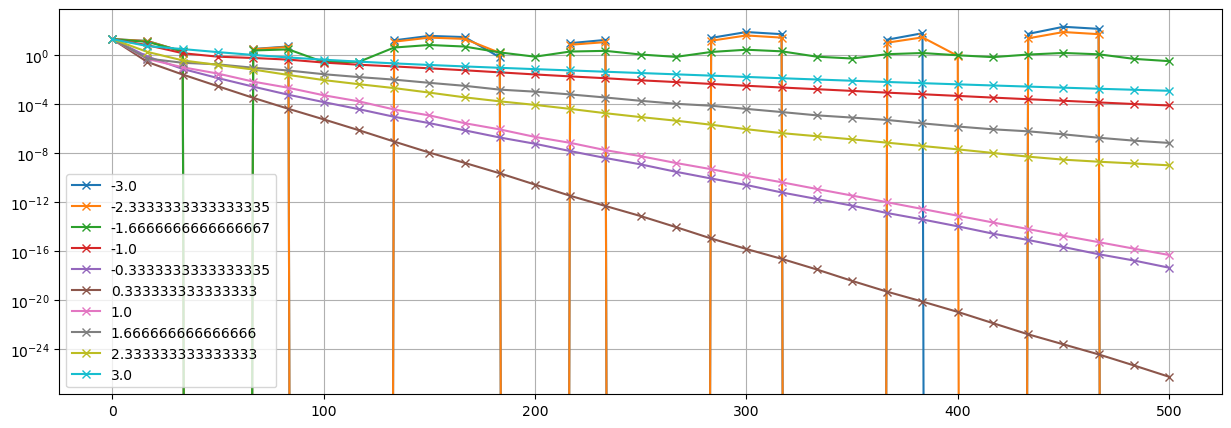

In [74]:
steps = tspan.shape[0]//30
plt.figure(figsize=(15, 5))
conv_factor_obs = np.zeros(nb_gamma)
conv_factor_the = np.zeros(nb_gamma)
for i,gamma in enumerate(gamma_list):
    plt.semilogy(tspan[::steps],H_half_times_L2_norm(fX_sol[i][0:,::steps],frequencesmini),'-x',label=np.log10(gamma))
    conv_factor_obs[i] = np.polyfit(tspan[::steps],np.log(H_half_times_L2_norm(fX_sol[i][0:,::steps],frequencesmini)),1)[0]
plt.grid()
plt.legend()
plt.show()

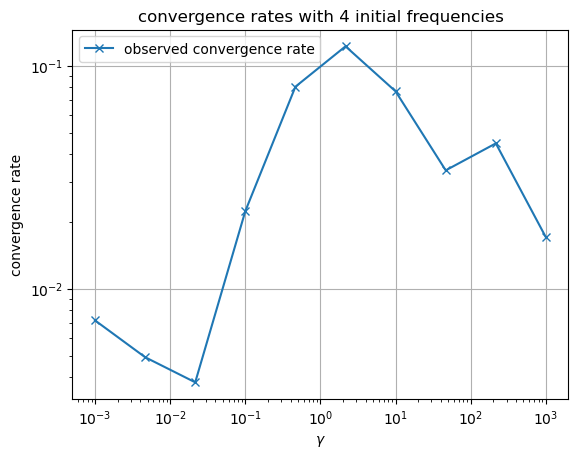

In [75]:
plt.loglog(gamma_list,np.abs(conv_factor_obs),'x-',label='observed convergence rate')
#plt.semilogx(gamma_list,conv_factor_the,'o-',label='theorical convergence rate')
plt.ylabel(r'convergence rate')
plt.xlabel(r'$\gamma$')
plt.legend()
plt.title('convergence rates with %i initial frequencies' % N_ini_fq)
plt.grid()

<function matplotlib.pyplot.grid(visible=None, which='major', axis='both', **kwargs)>

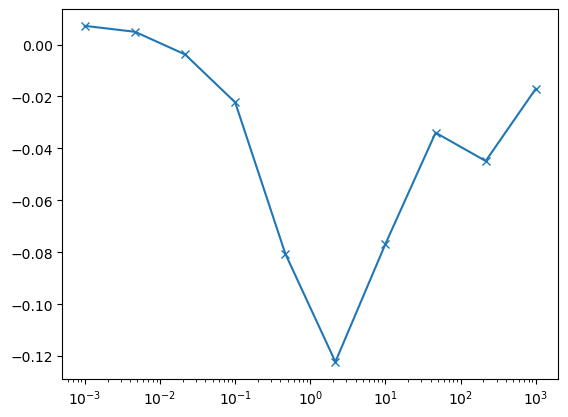

In [77]:
plt.semilogx(gamma_list,conv_factor_obs,'x-',label='observed convergence rate')
plt.grid

In [30]:
np.linalg.eig(fAB)[1][0:33,0]

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j])

In [22]:
# Lebau - Zuazua Null-contrilability - Theorem 3

(66, 66)

### Valeurs propres de $(-\Delta)^{1/2}$

In [57]:
eig_val_G, eig_vec_G = np.linalg.eig(G)
eig_val_fF, eig_vec_fF = np.linalg.eig(fF)

In [4]:
# test to see if the eigenvalues of (-\Delta)^{1/2} = freqs
np.linalg.norm(np.sort(eig_val_G) - np.sort(np.abs(frequences)))

6.735129341039932e-14

In [49]:
eig_val_G

array([3.55271368e-15, 1.60000000e+01, 1.60000000e+01, 1.00000000e+00,
       1.00000000e+00, 1.50000000e+01, 1.50000000e+01, 2.00000000e+00,
       1.40000000e+01, 1.40000000e+01, 2.00000000e+00, 1.30000000e+01,
       1.30000000e+01, 3.00000000e+00, 3.00000000e+00, 1.20000000e+01,
       1.20000000e+01, 4.00000000e+00, 4.00000000e+00, 5.00000000e+00,
       1.10000000e+01, 1.10000000e+01, 5.00000000e+00, 1.00000000e+01,
       1.00000000e+01, 6.00000000e+00, 6.00000000e+00, 9.00000000e+00,
       9.00000000e+00, 7.00000000e+00, 7.00000000e+00, 8.00000000e+00,
       8.00000000e+00])

In [58]:
eig_val_fF

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 16., 15., 14., 13., 12., 11., 10.,  9.,  8.,
        7.,  6.,  5.,  4.,  3.,  2.,  1.])

In [59]:
eig_vec_fF*np.exp()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [54]:
eig_vec_G[:,3]*2*np.pi

array([ 1.54383228,  1.53409863,  1.46891866,  1.35064814,  1.18356167,
        0.9736982 ,  0.72864275,  0.45725224,  0.16933545, -0.12470156,
       -0.41423154, -0.68879011, -0.93845401, -1.15419974, -1.32822968,
       -1.45425394, -1.52771767, -1.54596571, -1.50833852, -1.41619604,
       -1.27286855, -1.08353627, -0.85504217, -0.59564462, -0.31471892,
       -0.02241846,  0.27069227,  0.55401947,  0.81732296,  1.05108627,
        1.24686059,  1.39757012,  1.49776782])

In [56]:
np.real(np.exp(1j*xspan) + np.exp(-1j*xspan))

array([ 2.        ,  1.96385739,  1.85673587,  1.68250707,  1.44746808,
        1.16011382,  0.83083003,  0.47151787,  0.09516383, -0.28462968,
       -0.65413593, -1.        , -1.30972147, -1.57210619, -1.7776709 ,
       -1.91898595, -1.99094385, -1.99094385, -1.91898595, -1.7776709 ,
       -1.57210619, -1.30972147, -1.        , -0.65413593, -0.28462968,
        0.09516383,  0.47151787,  0.83083003,  1.16011382,  1.44746808,
        1.68250707,  1.85673587,  1.96385739])

### Valeurs propres de $A$

In [6]:
eig_val_A, eig_vec_A = np.linalg.eig(A)
eig_val_fA, eig_vec_fA = np.linalg.eig(fA)

In [8]:
np.imag(eig_val_fA)

array([ 1.41421356, -1.41421356,  1.41421356, -1.41421356,  2.        ,
       -2.        ,  2.44948974, -2.44948974,  2.82842712, -2.82842712,
        3.16227766, -3.16227766,  3.46410162, -3.46410162,  3.74165739,
       -3.74165739,  4.        , -4.        ,  3.87298335, -3.87298335,
        3.60555128, -3.60555128,  3.31662479, -3.31662479,  3.        ,
       -3.        ,  2.64575131, -2.64575131,  2.23606798, -2.23606798,
        1.73205081, -1.73205081,  1.        , -1.        ,  1.        ,
       -1.        ,  1.73205081, -1.73205081,  2.23606798, -2.23606798,
        2.64575131, -2.64575131,  3.        , -3.        ,  3.31662479,
       -3.31662479,  3.60555128, -3.60555128,  3.87298335, -3.87298335,
        4.        , -4.        ,  3.74165739, -3.74165739,  3.46410162,
       -3.46410162,  3.16227766, -3.16227766,  2.82842712, -2.82842712,
        2.44948974, -2.44948974,  2.        , -2.        ,  0.        ,
        0.        ])

In [7]:
np.imag(eig_val_fA)

array([ 1.41421356, -1.41421356,  1.41421356, -1.41421356,  2.        ,
       -2.        ,  2.44948974, -2.44948974,  2.82842712, -2.82842712,
        3.16227766, -3.16227766,  3.46410162, -3.46410162,  3.74165739,
       -3.74165739,  4.        , -4.        ,  3.87298335, -3.87298335,
        3.60555128, -3.60555128,  3.31662479, -3.31662479,  3.        ,
       -3.        ,  2.64575131, -2.64575131,  2.23606798, -2.23606798,
        1.73205081, -1.73205081,  1.        , -1.        ,  1.        ,
       -1.        ,  1.73205081, -1.73205081,  2.23606798, -2.23606798,
        2.64575131, -2.64575131,  3.        , -3.        ,  3.31662479,
       -3.31662479,  3.60555128, -3.60555128,  3.87298335, -3.87298335,
        4.        , -4.        ,  3.74165739, -3.74165739,  3.46410162,
       -3.46410162,  3.16227766, -3.16227766,  2.82842712, -2.82842712,
        2.44948974, -2.44948974,  2.        , -2.        ,  0.        ,
        0.        ])

In [91]:
fA @ eig_vec_fA[:,np.imag(eig_val_fA)==0][:,1]

array([-6.61375559e-291+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
        0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
        0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
        0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
        0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
        0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
        0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
        0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
        0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
        0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
        0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
        0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
        0.00000000e+000+0.j,  0.00000000e+000+0.j,  0.00000000e+000+0.j,
        0.00000000e+000+0.j,  0.00000000e+000+0.j, 

In [89]:
z_phi = np.zeros(33) + np.zeros(33)*1j
z_eta = z_phi.copy()
z_phi[1] = 1
z_eta[1] = -1j
zz = np.concatenate((z_phi,z_eta))

print(np.linalg.norm(fA @ zz - 1j * zz))

z_phi = np.zeros(33) + np.zeros(33)*1j
z_eta = z_phi.copy()
z_phi[2] = 1
z_eta[2] = -1j*np.sqrt(2)
zz = np.concatenate((z_phi,z_eta))

print(np.linalg.norm(fA @ zz - 1j*np.sqrt(2) * zz))

0.0
4.440892098500626e-16


array([ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -0.-1.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j])

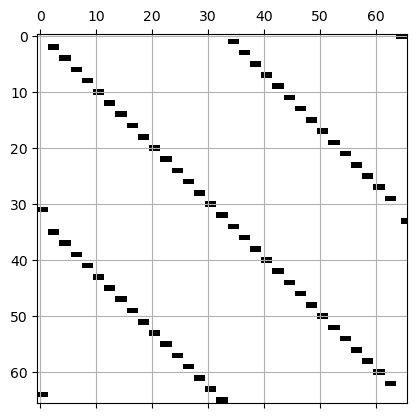

In [28]:
plt.spy(eig_vec_fA)
plt.grid()
plt.show()

In [7]:
np.linalg.norm(np.sort(np.imag(eig_val_A)) - np.sort(np.concatenate((np.sqrt(np.abs(frequences)),-np.sqrt(np.abs(frequences))))))

3.545142216381172e-14

les valeurs propres de A sont doubles et son les $(-i\sqrt{|k|},i\sqrt{|k|})$

In [8]:
np.sort(np.concatenate((np.sqrt(np.abs(frequences)),-np.sqrt(np.abs(frequences)))))

array([-4.        , -4.        , -3.87298335, -3.87298335, -3.74165739,
       -3.74165739, -3.60555128, -3.60555128, -3.46410162, -3.46410162,
       -3.31662479, -3.31662479, -3.16227766, -3.16227766, -3.        ,
       -3.        , -2.82842712, -2.82842712, -2.64575131, -2.64575131,
       -2.44948974, -2.44948974, -2.23606798, -2.23606798, -2.        ,
       -2.        , -1.73205081, -1.73205081, -1.41421356, -1.41421356,
       -1.        , -1.        , -0.        ,  0.        ,  1.        ,
        1.        ,  1.41421356,  1.41421356,  1.73205081,  1.73205081,
        2.        ,  2.        ,  2.23606798,  2.23606798,  2.44948974,
        2.44948974,  2.64575131,  2.64575131,  2.82842712,  2.82842712,
        3.        ,  3.        ,  3.16227766,  3.16227766,  3.31662479,
        3.31662479,  3.46410162,  3.46410162,  3.60555128,  3.60555128,
        3.74165739,  3.74165739,  3.87298335,  3.87298335,  4.        ,
        4.        ])

In [41]:
np.imag(eig_val_A[10])

0.9999999999999939

In [45]:
eig_vec_A[:,10]

array([ 1.73124778e-01-0.00079579j,  1.73052201e-01+0.00079579j,
        1.66725067e-01+0.0023586j ,  1.54372054e-01+0.00383616j,
        1.36439633e-01+0.00517508j,  1.13575929e-01+0.00632695j,
        8.66072943e-02+0.00725016j,  5.65084464e-02+0.00791132j,
        2.43672360e-02+0.00828655j, -8.65466974e-03+0.00836228j,
       -4.13637732e-02+0.00813577j, -7.25778821e-02+0.00761522j,
       -1.01168837e-01+0.00681943j, -1.26103287e-01+0.00577718j,
       -1.46480035e-01+0.00452612j, -1.61562614e-01+0.00311147j,
       -1.70805898e-01+0.00158437j, -1.73875813e-01+0.j        ,
       -1.70661402e-01-0.00158437j, -1.61278844e-01-0.00311147j,
       -1.46067248e-01-0.00452612j, -1.25576401e-01-0.00577718j,
       -1.00546896e-01-0.00681943j, -7.18833638e-02-0.00761522j,
       -4.06217798e-02-0.00813577j, -7.89201882e-03-0.00836228j,
        2.51229803e-02-0.00828655j,  5.72299694e-02-0.00791132j,
        8.72685183e-02-0.00725016j,  1.14152956e-01-0.00632695j,
        1.36911608e-01-0.

In [ ]:
np.exp(1j*)

array([ 2.        +0.j,  1.96385739+0.j,  1.85673587+0.j,  1.68250707+0.j,
        1.44746808+0.j,  1.16011382+0.j,  0.83083003+0.j,  0.47151787+0.j,
        0.09516383+0.j, -0.28462968+0.j, -0.65413593+0.j, -1.        +0.j,
       -1.30972147+0.j, -1.57210619+0.j, -1.7776709 +0.j, -1.91898595+0.j,
       -1.99094385+0.j, -1.99094385+0.j, -1.91898595+0.j, -1.7776709 +0.j,
       -1.57210619+0.j, -1.30972147+0.j, -1.        +0.j, -0.65413593+0.j,
       -0.28462968+0.j,  0.09516383+0.j,  0.47151787+0.j,  0.83083003+0.j,
        1.16011382+0.j,  1.44746808+0.j,  1.68250707+0.j,  1.85673587+0.j,
        1.96385739+0.j])

In [41]:
np.floor(np.random.rand()*21)+1

11.0